# Championship 2023-2024 Predictions

In [344]:
# import data
import pandas as pd
import numpy as np

#df = pd.read_csv('F2.csv')
#df = pd.read_csv('ligue_2.csv')
df = pd.read_csv('scrapers/football_scraper/englandm/E0.csv')
#df = pd.read_csv('scrapers/football_scraper/belgiumm/B1.csv')
#df = pd.read_csv('f2_new.csv')
df.tail()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
211,E0,30/01/2024,20:00,Crystal Palace,Sheffield United,3,2,H,2,2,...,1.85,-1.0,2.11,1.82,2.10,1.84,2.14,1.87,2.08,1.81
212,E0,30/01/2024,20:15,Aston Villa,Newcastle,1,3,A,0,2,...,2.47,-0.5,1.85,2.08,1.87,2.06,1.88,2.09,1.86,2.03
213,E0,31/01/2024,19:30,Man City,Burnley,3,1,H,2,0,...,3.38,-2.5,2.00,1.80,2.04,1.87,2.09,1.95,2.00,1.86
214,E0,31/01/2024,19:30,Tottenham,Brentford,3,2,H,0,1,...,2.79,-1.0,2.00,1.90,2.00,1.92,2.15,1.96,2.02,1.86
215,E0,31/01/2024,20:15,Liverpool,Chelsea,4,1,H,2,0,...,2.68,-1.0,2.06,1.84,2.10,1.84,2.14,1.88,2.05,1.83


In [345]:
## Data Cleaning

In [346]:
# steps:
# 1. Check for missing values
missing_values = df.isnull().sum()

# 2. Check for duplicates
duplicate_rows = df.duplicated().sum()

# Display the results of the checks
missing_values, duplicate_rows

(Div         0
 Date        0
 Time        0
 HomeTeam    0
 AwayTeam    0
            ..
 PCAHA       0
 MaxCAHH     1
 MaxCAHA     1
 AvgCAHH     0
 AvgCAHA     0
 Length: 106, dtype: int64,
 0)

In [347]:
# Checking for missing values
missing_values = df.isnull().sum()




# Checking the balance of the target variable 'FTR'
target_distribution = df['FTR'].value_counts()

# drop the div column
df.drop('Div', axis=1, inplace=True)
df.drop('Time', axis=1, inplace=True)

missing_values, target_distribution


(Div         0
 Date        0
 Time        0
 HomeTeam    0
 AwayTeam    0
            ..
 PCAHA       0
 MaxCAHH     1
 MaxCAHA     1
 AvgCAHH     0
 AvgCAHA     0
 Length: 106, dtype: int64,
 FTR
 H    103
 A     70
 D     43
 Name: count, dtype: int64)

In [348]:
# covert date to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

## Feature engineering

### steps:
* Encode Team Names: Use label encoding for 'HomeTeam' and 'AwayTeam'. This will convert team names into numeric values, making them usable for the model.

* Recent Form: Calculate the recent form for each team based on the last 5 matches. We'll use the 'FTR' column to determine wins (W), losses (L), and draws (D). This feature will provide insight into the current performance of the teams.

* Average Goals per Game: Compute the average goals scored per game for both home and away teams. This feature helps understand the offensive strength of the teams.

* Team Points: Calculate the total points accumulated by each team so far in the season. Points are awarded based on wins (3 points), draws (1 point), and losses (0 points).

* Head-to-Head Statistics: Analyze the outcomes of matches between the same pairs of teams earlier in the season.

* Other Statistical Features: Depending on the data available, we can include additional features like average possession, number of shots on target, defensive strength, etc.

In [349]:
# Reset the index of the DataFrame (if necessary)
df.reset_index(drop=True, inplace=True)

# Rolling averages for goals
window_sizes = [3, 5]
for window in window_sizes:
    df[f'HomeGoalsScoredAvg_{window}'] = df.groupby('HomeTeam')['FTHG'].transform(lambda x: x.rolling(window, min_periods=1).mean())
    df[f'AwayGoalsScoredAvg_{window}'] = df.groupby('AwayTeam')['FTAG'].transform(lambda x: x.rolling(window, min_periods=1).mean())
    df[f'HomeGoalsConcededAvg_{window}'] = df.groupby('HomeTeam')['FTAG'].transform(lambda x: x.rolling(window, min_periods=1).mean())
    df[f'AwayGoalsConcededAvg_{window}'] = df.groupby('AwayTeam')['FTHG'].transform(lambda x: x.rolling(window, min_periods=1).mean())



In [350]:

# Variance in team performance
df['HomeGoalsScoredVariance'] = df.groupby('HomeTeam')['FTHG'].transform(lambda x: x.rolling(5, min_periods=1).var())
df['AwayGoalsScoredVariance'] = df.groupby('AwayTeam')['FTAG'].transform(lambda x: x.rolling(5, min_periods=1).var())




In [351]:


from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Combine all unique team names from both HomeTeam and AwayTeam columns
all_teams = pd.concat([df['HomeTeam'], df['AwayTeam']]).unique()

# Fit the LabelEncoder with all unique team names
label_encoder.fit(all_teams)

# Transform both HomeTeam and AwayTeam using the fitted LabelEncoder
df['HomeTeam_encoded'] = label_encoder.transform(df['HomeTeam'])
df['AwayTeam_encoded'] = label_encoder.transform(df['AwayTeam'])

# # Now you can transform individual team names
# home_team_encoded = label_encoder.transform(['St Etienne'])[0]
# away_team_encoded = label_encoder.transform(['Laval'])[0]

# # Debugging: Print encoded values
# print(f"Encoded Home Team: {home_team_encoded}, Encoded Away Team: {away_team_encoded}")

print(label_encoder.classes_)


['Arsenal' 'Aston Villa' 'Bournemouth' 'Brentford' 'Brighton' 'Burnley'
 'Chelsea' 'Crystal Palace' 'Everton' 'Fulham' 'Liverpool' 'Luton'
 'Man City' 'Man United' 'Newcastle' "Nott'm Forest" 'Sheffield United'
 'Tottenham' 'West Ham' 'Wolves']


In [352]:
df.tail()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,HomeGoalsConcededAvg_3,AwayGoalsConcededAvg_3,HomeGoalsScoredAvg_5,AwayGoalsScoredAvg_5,HomeGoalsConcededAvg_5,AwayGoalsConcededAvg_5,HomeGoalsScoredVariance,AwayGoalsScoredVariance,HomeTeam_encoded,AwayTeam_encoded
211,2024-01-30,Crystal Palace,Sheffield United,3,2,H,2,2,D,T Harrington,...,1.333333,2.000000,1.6,0.6,1.6,2.6,1.8,0.8,7,16
212,2024-01-30,Aston Villa,Newcastle,1,3,A,0,2,A,J Brooks,...,2.000000,2.000000,1.4,1.2,1.2,2.6,0.8,1.7,1,14
213,2024-01-31,Man City,Burnley,3,1,H,2,0,H,S Barrott,...,1.000000,2.000000,2.2,1.2,1.4,1.6,0.7,0.7,12,5
214,2024-01-31,Tottenham,Brentford,3,2,H,0,1,A,D Coote,...,1.333333,2.333333,2.6,0.8,1.4,2.4,1.3,0.7,17,3
215,2024-01-31,Liverpool,Chelsea,4,1,H,2,0,H,P Tierney,...,1.333333,2.666667,2.6,1.2,1.4,2.4,3.8,1.2,10,6


In [353]:
# Encoding the target variable 'FTR'
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target variable using label_encoder_y
df['FTR_encoded'] = label_encoder.fit_transform(df['FTR'])




In [354]:

# Average points per game
df['HomeTeamPoints'] = df.groupby('HomeTeam')['FTR_encoded'].transform(lambda x: x.expanding().sum().shift(1)) / df.groupby('HomeTeam')['FTR_encoded'].transform(lambda x: x.expanding().count().shift(1))
df['AwayTeamPoints'] = df.groupby('AwayTeam')['FTR_encoded'].transform(lambda x: x.expanding().sum().shift(1)) / df.groupby('AwayTeam')['FTR_encoded'].transform(lambda x: x.expanding().count().shift(1))



In [355]:
# Average goals per game
df['HomeTeamAvgGoals'] = df.groupby('HomeTeam')['FTHG'].transform(lambda x: x.expanding().mean().shift(1)) # Average goals scored by the home team
df['AwayTeamAvgGoals'] = df.groupby('AwayTeam')['FTAG'].transform(lambda x: x.expanding().mean().shift(1)) # Average goals scored by the away team



In [356]:
# recent form
def calculate_form_points(team, df):
    # Get the last 5 matches of the home and away teams
    home_matches = df[df['HomeTeam'] == team].tail(5)
    away_matches = df[df['AwayTeam'] == team].tail(5)

    # Calculate the points obtained in the last 5 matches
    home_points = home_matches['FTR_encoded'].sum()
    away_points = away_matches['FTR_encoded'].sum()

    # Calculate the average points obtained
    home_avg_points = home_points / 15
    away_avg_points = away_points / 15

    # Return the average points
    return home_avg_points, away_avg_points

# Calculate the average points obtained by each team in the last 5 matches
df['HomeTeamRecentForm'], df['AwayTeamRecentForm'] = zip(*df['HomeTeam'].apply(lambda x: calculate_form_points(x, df)))



## League Standings

In [357]:
# Assuming df is your DataFrame with the match data
df['HomeWin'] = df['FTHG'] > df['FTAG']
df['AwayWin'] = df['FTAG'] > df['FTHG']
df['Draw'] = df['FTHG'] == df['FTAG']

# Assign points based on outcomes
df['HomePoints'] = df['HomeWin'] * 3 + df['Draw'] * 1
df['AwayPoints'] = df['AwayWin'] * 3 + df['Draw'] * 1

# Combine home and away games into a single DataFrame for point calculation
points_df = pd.concat([
    df[['Date', 'HomeTeam', 'HomePoints']].rename(columns={'HomeTeam': 'Team', 'HomePoints': 'Points'}),
    df[['Date', 'AwayTeam', 'AwayPoints']].rename(columns={'AwayTeam': 'Team', 'AwayPoints': 'Points'})
])

# Sort by match date to ensure chronological order
points_df.sort_values(by=['Date'], inplace=True)

# Calculate cumulative points for each team
points_df['CumulativePoints'] = points_df.groupby('Team')['Points'].cumsum()

# Prepare for merging by shifting cumulative points to represent standings before the match
points_df['CumulativePoints'] = points_df.groupby('Team')['CumulativePoints'].shift(fill_value=0)

# Merge back into the original DataFrame to associate standings with each match
df = df.merge(points_df[['Date', 'Team', 'CumulativePoints']], 
              left_on=['Date', 'HomeTeam'], 
              right_on=['Date', 'Team'], 
              how='left').rename(columns={'CumulativePoints': 'HomeTeamStandingBeforeMatch'}).drop('Team', axis=1)

df = df.merge(points_df[['Date', 'Team', 'CumulativePoints']], 
              left_on=['Date', 'AwayTeam'], 
              right_on=['Date', 'Team'], 
              how='left').rename(columns={'CumulativePoints': 'AwayTeamStandingBeforeMatch'}).drop('Team', axis=1)

# Display the updated DataFrame with team standings before each match

# Display the DataFrame 
df.tail(20)

# get the league standings




,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,AwayTeamAvgGoals,HomeTeamRecentForm,AwayTeamRecentForm,HomeWin,AwayWin,Draw,HomePoints,AwayPoints,HomeTeamStandingBeforeMatch,AwayTeamStandingBeforeMatch
196,2024-01-01,Liverpool,Newcastle,4,2,H,0,0,D,A Taylor,...,1.555556,0.533333,0.066667,True,False,False,3,0,42,29
197,2024-01-02,West Ham,Brighton,0,0,D,0,0,D,S Barrott,...,1.777778,0.533333,0.200000,False,False,True,1,1,33,30
198,2024-01-12,Burnley,Luton,1,1,D,1,0,H,T Harrington,...,1.111111,0.200000,0.466667,False,False,True,1,1,11,15
199,2024-01-13,Chelsea,Fulham,1,0,H,1,0,H,A Taylor,...,0.900000,0.600000,0.533333,True,False,False,3,0,28,24
200,2024-01-13,Newcastle,Man City,2,3,A,2,1,H,C Kavanagh,...,2.100000,0.400000,0.533333,False,True,False,0,3,29,40
201,2024-01-14,Everton,Aston Villa,0,0,D,0,0,D,D Coote,...,1.400000,0.333333,0.333333,False,False,True,1,1,26,42
202,2024-01-14,Man United,Tottenham,2,2,D,2,1,H,J Brooks,...,2.200000,0.466667,0.466667,False,False,True,1,1,31,39
203,2024-01-20,Arsenal,Crystal Palace,5,0,H,2,0,H,P Tierney,...,1.100000,0.533333,0.333333,True,False,False,3,0,40,21
204,2024-01-20,Brentford,Nott'm Forest,3,2,H,1,1,D,D England,...,1.000000,0.266667,0.666667,True,False,False,3,0,19,20
205,2024-01-21,Sheffield United,West Ham,2,2,D,1,1,D,M Salisbury,...,1.600000,0.200000,0.600000,False,False,True,1,1,9,34


### League standings

In [358]:
# getting the league standings
# Aggregate points for each team
home_points = df.groupby('HomeTeam')['HomePoints'].sum().reset_index()
away_points = df.groupby('AwayTeam')['AwayPoints'].sum().reset_index()

# Merge and sum the points for total points
points = pd.merge(home_points, away_points, left_on='HomeTeam', right_on='AwayTeam', how='outer', suffixes=('_home', '_away')).fillna(0)
points['Team'] = points['HomeTeam'].combine_first(points['AwayTeam'])
points['TotalPoints'] = points['HomePoints'] + points['AwayPoints']

# Calculate goal difference for tiebreakers
home_goals = df.groupby('HomeTeam').agg({'FTHG':'sum', 'FTAG':'sum'}).reset_index().rename(columns={'FTHG': 'GoalsFor_home', 'FTAG': 'GoalsAgainst_home'})
away_goals = df.groupby('AwayTeam').agg({'FTAG':'sum', 'FTHG':'sum'}).reset_index().rename(columns={'FTAG': 'GoalsFor_away', 'FTHG': 'GoalsAgainst_away'})

goals = pd.merge(home_goals, away_goals, left_on='HomeTeam', right_on='AwayTeam', how='outer', suffixes=('_home', '_away')).fillna(0)
goals['Team'] = goals['HomeTeam'].combine_first(goals['AwayTeam'])
goals['GoalDifference'] = (goals['GoalsFor_home'] + goals['GoalsFor_away']) - (goals['GoalsAgainst_home'] + goals['GoalsAgainst_away'])

# Merge points and goals to get a complete standing
standings = pd.merge(points[['Team', 'TotalPoints']], goals[['Team', 'GoalDifference']], on='Team')

# Sort teams by Total Points and Goal Difference
standings.sort_values(by=['TotalPoints', 'GoalDifference'], ascending=[False, False], inplace=True)

# Reset index to get ranking
standings.reset_index(drop=True, inplace=True)

# Display the league standings
print(standings.head(20))

                Team  TotalPoints  GoalDifference
0          Liverpool           51              32
1           Man City           46              27
2            Arsenal           46              23
3        Aston Villa           43              14
4          Tottenham           43              14
5           West Ham           35               3
6          Newcastle           32              11
7           Brighton           32               1
8         Man United           32              -5
9            Chelsea           31               1
10            Wolves           29              -1
11           Everton           28              -4
12            Fulham           25              -8
13       Bournemouth           25             -11
14    Crystal Palace           24             -11
15         Brentford           22              -5
16     Nott'm Forest           20             -13
17             Luton           19             -10
18           Burnley           12             -23


In [359]:
# Assuming 'standings' DataFrame is already sorted by TotalPoints and GoalDifference

# Add a 'Position' column based on the sorted standings
standings['Position'] = standings.reset_index().index + 1

# Create a dictionary to map team names to their positions
team_position_map = standings.set_index('Team')['Position'].to_dict()

# Map the home and away team positions for each match in the original DataFrame
df['HomeTeamPosition'] = df['HomeTeam'].map(team_position_map)
df['AwayTeamPosition'] = df['AwayTeam'].map(team_position_map)

# Now, 'df' includes the league positions of both home and away teams for each match
#print(df[['Date', 'HomeTeam', 'AwayTeam', 'HomeTeamPosition', 'AwayTeamPosition']].head())

df.tail()


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,AwayTeamRecentForm,HomeWin,AwayWin,Draw,HomePoints,AwayPoints,HomeTeamStandingBeforeMatch,AwayTeamStandingBeforeMatch,HomeTeamPosition,AwayTeamPosition
211,2024-01-30,Crystal Palace,Sheffield United,3,2,H,2,2,D,T Harrington,...,0.533333,True,False,False,3,0,21,10,15,20
212,2024-01-30,Aston Villa,Newcastle,1,3,A,0,2,A,J Brooks,...,0.266667,False,True,False,0,3,43,29,4,7
213,2024-01-31,Man City,Burnley,3,1,H,2,0,H,S Barrott,...,0.200000,True,False,False,3,0,43,12,2,19
214,2024-01-31,Tottenham,Brentford,3,2,H,0,1,A,D Coote,...,0.400000,True,False,False,3,0,40,22,5,16
215,2024-01-31,Liverpool,Chelsea,4,1,H,2,0,H,P Tierney,...,0.066667,True,False,False,3,0,48,31,1,10


In [360]:
from sklearn.model_selection import train_test_split

# Convert 'Date' to datetime and extract useful features
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df['DayOfWeek'] = df['Date'].dt.dayofweek  # 0: Monday, 6: Sunday
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)  # 1 for weekend, 0 for weekdays



In [361]:
#select relevant columns or features and the target
features = [
    'HomeTeam_encoded', 'AwayTeam_encoded', 'HomeTeamRecentForm', 'AwayTeamRecentForm', 
    'HomeTeamAvgGoals', 'AwayTeamAvgGoals', 'HomeTeamPoints', 'AwayTeamPoints', 'HomeGoalsScoredVariance', 'AwayGoalsScoredVariance', 'HomeGoalsScoredAvg_3', 'AwayGoalsScoredAvg_3', 'HomeGoalsConcededAvg_3', 'AwayGoalsConcededAvg_3', 'HomeGoalsScoredAvg_5', 'AwayGoalsScoredAvg_5', 'HomeGoalsConcededAvg_5', 'AwayGoalsConcededAvg_5', 'HomeTeamPosition', 'AwayTeamPosition', 'HomeTeamStandingBeforeMatch', 'AwayTeamStandingBeforeMatch',
]

target = 'FTR_encoded'

# Split the data into training and test sets
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_test_split(X, y, test_size=0.2, random_state=42)

# Previewing the processed features
X_train.head(7), y_train.head(7)

# encoding the categorical variables
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target variable using label_encoder_y
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


In [362]:
# scaling the features
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the StandardScaler
scaler.fit(X_train)

# Transform both the training and testing sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)



### Create Model


In [363]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize the models
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
lgbm_model = LGBMClassifier(random_state=42)   
catboost_model = CatBoostClassifier(random_state=42, verbose=False)


# Train the models
#rf_model.fit(X_train, y_train_encoded)
xgb_model.fit(X_train_scaled, y_train_encoded)
lgbm_model.fit(X_train_scaled, y_train_encoded)
catboost_model.fit(X_train_scaled, y_train_encoded)







[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 494
[LightGBM] [Info] Number of data points in the train set: 172, number of used features: 22
[LightGBM] [Info] Start training from score -0.988611
[LightGBM] [Info] Start training from score -1.681759
[LightGBM] [Info] Start training from score -0.816761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

In [364]:
from sklearn.metrics import roc_auc_score

#evaluate the models using the metrics
models = [ xgb_model, lgbm_model, catboost_model]
model_names = [ 'XGBoost', 'LightGBM', 'CatBoost']

# Calculate ROC AUC Score

for model, name in zip(models, model_names):
    # Predict class labels for the test set
    y_pred = model.predict(X_test)
    
    # Get probabilities instead of predicted labels for ROC AUC
    y_prob = model.predict_proba(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    
    # Calculate ROC AUC score using probabilities
    # Note: Ensure y_test is properly encoded if necessary
    roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovo')
    
    print(f"{name} Model Metrics")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"ROC AUC: {roc_auc}")
    print("\n")
    
    

XGBoost Model Metrics
Accuracy: 0.5681818181818182
Precision: 0.41568627450980394
Recall: 0.4130190796857463
F1 Score: 0.40331594634873325
ROC AUC: 0.590347923681257


LightGBM Model Metrics
Accuracy: 0.6136363636363636
Precision: 0.20930232558139536
Recall: 0.3333333333333333
F1 Score: 0.2571428571428572
ROC AUC: 0.5726711560044894


CatBoost Model Metrics
Accuracy: 0.6136363636363636
Precision: 0.3729166666666666
Recall: 0.5061728395061729
F1 Score: 0.42655367231638414
ROC AUC: 0.650579872802095


# Feature Importance with recursive feature elimination

In [383]:
from sklearn.feature_selection import RFE
import xgboost as xgb

# Assuming X_train is your features DataFrame and y_train is the target series
xgb_estimator = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

# Create the RFE object and rank each feature
rfe = RFE(estimator=xgb_estimator, n_features_to_select=10, step=1)
rfe.fit(X_train, y_train)

# Selected features are marked as True in rfe.support_ and their ranking is in rfe.ranking_
print('Selected features:', list(X_train.columns[rfe.support_]))
print('Feature rankings:', rfe.ranking_)


Selected features: ['AwayTeam_encoded', 'AwayTeamPoints', 'HomeGoalsScoredAvg_3', 'AwayGoalsScoredAvg_3', 'HomeGoalsConcededAvg_3', 'AwayGoalsConcededAvg_3', 'HomeGoalsScoredAvg_5', 'AwayGoalsConcededAvg_5', 'AwayTeamPosition', 'HomeTeamStandingBeforeMatch']
Feature rankings: [ 2  1 10  7  5 12  9  1  4  6  1  1  1  1  1  3  8  1 11  1  1 13]


In [384]:
from sklearn.feature_selection import RFE
from catboost import CatBoostClassifier

# Assuming X_train is your features DataFrame and y_train is the target series
cat_estimator = CatBoostClassifier(verbose=0)

# Create the RFE object and rank each feature
rfe = RFE(estimator=cat_estimator, n_features_to_select=10, step=1)
rfe.fit(X_train, y_train)

# Selected features are marked as True in rfe.support_ and their ranking is in rfe.ranking_
print('Selected features:', list(X_train.columns[rfe.support_]))
print('Feature rankings:', rfe.ranking_)


Selected features: ['HomeTeam_encoded', 'AwayGoalsScoredVariance', 'HomeGoalsScoredAvg_3', 'AwayGoalsScoredAvg_3', 'HomeGoalsConcededAvg_3', 'AwayGoalsConcededAvg_3', 'HomeGoalsScoredAvg_5', 'HomeGoalsConcededAvg_5', 'AwayGoalsConcededAvg_5', 'AwayTeamStandingBeforeMatch']
Feature rankings: [ 1  5  3 13  6 11 12  9  2  1  1  1  1  1  1  8  1  1  7  4 10  1]


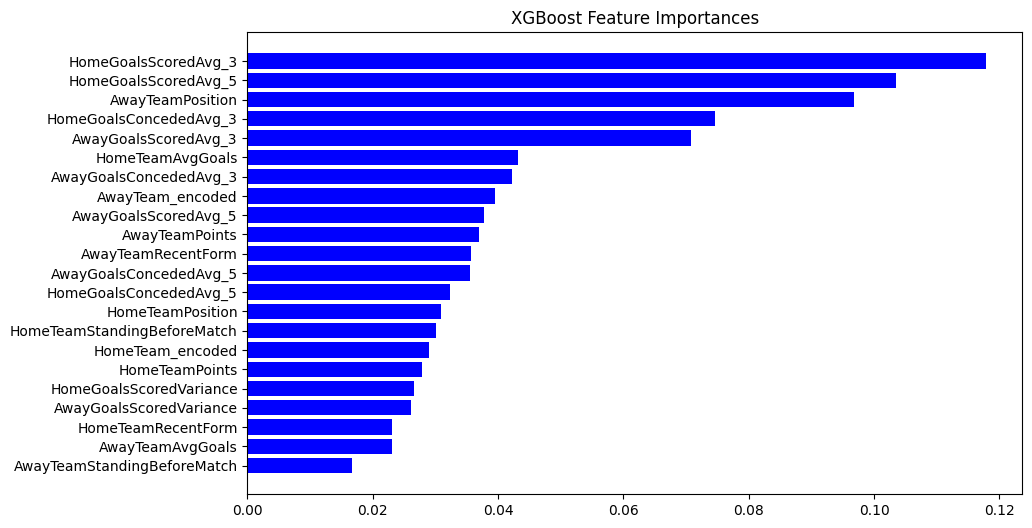

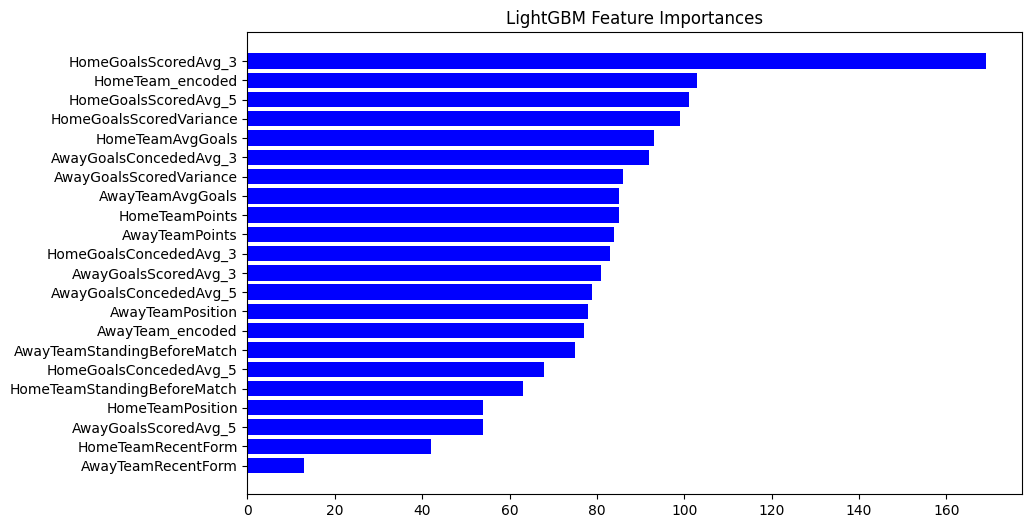

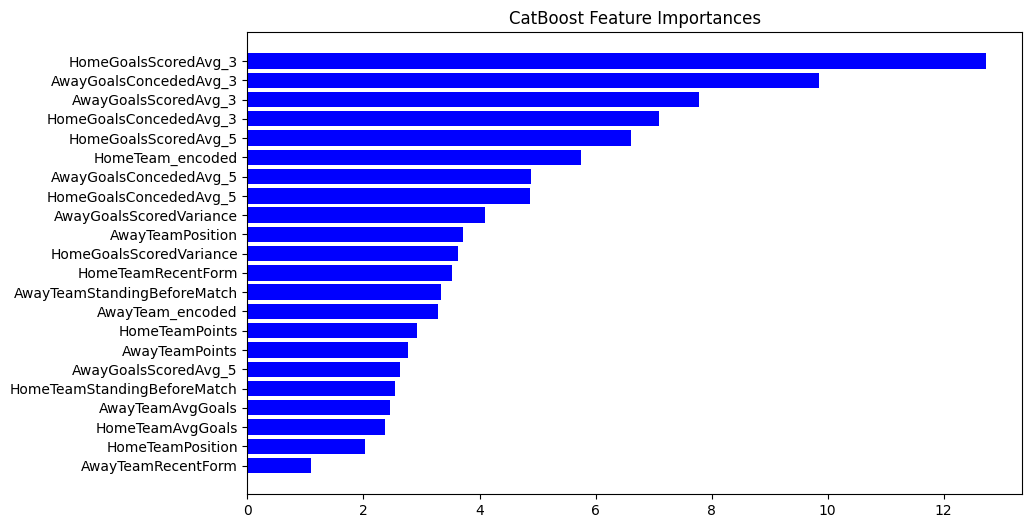

In [365]:
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importances(importances, model_name, feature_names):
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.title(f'{model_name} Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
    plt.show()

# Assuming X_train is your feature DataFrame with proper column names
feature_names = X_train.columns

# Your models list
models = [xgb_model, lgbm_model, catboost_model]
model_names = ['XGBoost', 'LightGBM', 'CatBoost']  # Ensure this matches your models list

for model, name in zip(models, model_names):
    # CatBoost has a different method for getting feature importance
    if name == 'CatBoost':
        importances = model.get_feature_importance()
    else:  # This works for XGBoost, LightGBM, and potentially others like RandomForest
        importances = model.feature_importances_
    
    plot_feature_importances(importances, name, feature_names)


# creating objective function and hyper opts for hyperparaemters

In [366]:
from hyperopt import hp
import numpy as np
# Define the hyperparameter space
space = {
    'iterations': hp.quniform('iterations', 100, 1000, 50),
    'depth': hp.choice('depth', np.arange(3, 11, dtype=int)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),
    'bagging_temperature': hp.uniform('bagging_temperature', 0, 1),
    'random_strength': hp.uniform('random_strength', 0, 1),
    

}


In [367]:
from sklearn.model_selection import cross_val_score
from hyperopt import STATUS_OK
from sklearn.model_selection import StratifiedKFold


def objective(params):
    params['iterations'] = int(params['iterations'])
    clf = CatBoostClassifier(**params, loss_function='MultiClass', verbose=False)
    score = cross_val_score(clf, X_train_scaled, y_train_encoded, scoring='accuracy', cv=StratifiedKFold(5)).mean()
    return {'loss': -score, 'status': STATUS_OK}



In [368]:
# run the hyperparameter optimization
from hyperopt import tpe, Trials, fmin

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)


100%|██████████| 10/10 [02:21<00:00, 14.12s/trial, best loss: -0.692436974789916]


In [369]:
from sklearn.metrics import classification_report

best_params = {k: int(v) if k in ['iterations', 'depth'] else v for k, v in best.items()}
final_model = CatBoostClassifier(**best_params, loss_function='MultiClass', eval_metric='Accuracy', verbose=False)
final_model.fit(X_train_scaled, y_train_encoded)

# Evaluate the model
y_pred = final_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.31      0.67      0.42         6
           1       0.00      0.00      0.00        11
           2       0.78      0.78      0.78        27

    accuracy                           0.57        44
   macro avg       0.36      0.48      0.40        44
weighted avg       0.52      0.57      0.53        44


# Xgboost with params

In [370]:
# hyperparameter tuning for xgboost using hyperopt
from hyperopt import hp
import numpy as np
# Define the hyperparameter space

space = {
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 50),
    'max_depth': hp.choice('max_depth', np.arange(3, 11, dtype=int)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'reg_lambda': hp.uniform('reg_lambda', 1, 10),
    'reg_alpha': hp.uniform('reg_alpha', 1, 10),
    'gamma': hp.uniform('gamma', 0, 1),
    'min_child_weight': hp.uniform('min_child_weight', 0, 10)
    
}

In [371]:
from hyperopt import STATUS_OK
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from xgboost import XGBClassifier

def objective(params):
    params['n_estimators'] = int(params['n_estimators'])
    clf = XGBClassifier(**params, objective='multi:softmax', num_class=3, eval_metric='mlogloss', verbosity=0)
    score = cross_val_score(clf, X_train_scaled, y_train_encoded, scoring='accuracy', cv=StratifiedKFold(10)).mean()
    return {'loss': -score, 'status': STATUS_OK}

In [372]:
# run the hyperparameter optimization
from hyperopt import tpe, Trials, fmin

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

from sklearn.metrics import classification_report

best_params = {k: int(v) if k in ['n_estimators', 'max_depth'] else v for k, v in best.items()}
best_model_2 = XGBClassifier(**best_params, objective='multi:softmax', num_class=3, eval_metric='mlogloss', verbosity=0)
best_model_2.fit(X_train_scaled, y_train_encoded)

100%|██████████| 100/100 [03:50<00:00,  2.31s/trial, best loss: -0.6977124183006536]


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.01399687150286236, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.10614312194452237, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=4.585882963292051, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=650,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

In [373]:
# Evaluate the model
y_pred = best_model_2.predict(X_test_scaled)
print(classification_report(y_test, y_pred, zero_division=0))


      

              precision    recall  f1-score   support

           0       0.25      0.50      0.33         6
           1       0.33      0.09      0.14        11
           2       0.79      0.85      0.82        27

    accuracy                           0.61        44
   macro avg       0.46      0.48      0.43        44
weighted avg       0.60      0.61      0.59        44


In [374]:

from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Combine all unique team names from both HomeTeam and AwayTeam columns
all_teams = pd.concat([df['HomeTeam'], df['AwayTeam']]).unique()

# Fit the LabelEncoder with all unique team names
label_encoder.fit(all_teams)

# Transform both HomeTeam and AwayTeam using the fitted LabelEncoder
df['HomeTeam_encoded'] = label_encoder.transform(df['HomeTeam'])
df['AwayTeam_encoded'] = label_encoder.transform(df['AwayTeam'])

# # Now you can transform individual team names
# home_team_encoded = label_encoder.transform(['St Etienne'])[0]
# away_team_encoded = label_encoder.transform(['Laval'])[0]
# 
# # Debugging: Print encoded values
# print(f"Encoded Home Team: {home_team_encoded}, Encoded Away Team: {away_team_encoded}")

print(label_encoder.classes_)


['Arsenal' 'Aston Villa' 'Bournemouth' 'Brentford' 'Brighton' 'Burnley'
 'Chelsea' 'Crystal Palace' 'Everton' 'Fulham' 'Liverpool' 'Luton'
 'Man City' 'Man United' 'Newcastle' "Nott'm Forest" 'Sheffield United'
 'Tottenham' 'West Ham' 'Wolves']


In [375]:
import pandas as pd

# Create an empty list to store match results
match_results = []
def predict_match(home_team, away_team, xgb_model, df, label_encoder):
     # Debugging: Check if the team names are in label_encoder's classes
    if home_team not in label_encoder.classes_:
        raise ValueError(f"Home team name '{home_team}' not recognized.")
    if away_team not in label_encoder.classes_:
        raise ValueError(f"Away team name '{away_team}' not recognized.")

    # Transform team names
    home_team_encoded = label_encoder.transform([home_team])[0]
    away_team_encoded = label_encoder.transform([away_team])[0]

    # Debugging: Print encoded values
   # print(f"Encoded Home Team: {home_team_encoded}, Encoded Away Team: {away_team_encoded}")

    # Prepare the match data with relevant features
    match_data = {
        'HomeTeam_encoded': label_encoder.transform([home_team])[0],
        'AwayTeam_encoded': label_encoder.transform([away_team])[0],
        'HomeTeamRecentForm': calculate_form_points(home_team, df)[0],
        'AwayTeamRecentForm': calculate_form_points(away_team, df)[1],
        'HomeTeamAvgGoals': df[df['HomeTeam'] == home_team]['FTHG'].mean(),
        'AwayTeamAvgGoals': df[df['AwayTeam'] == away_team]['FTAG'].mean(),
        'HomeTeamPoints': df[df['HomeTeam'] == home_team]['FTR_encoded'].sum() / df[df['HomeTeam'] == home_team]['FTR_encoded'].count(),
        'AwayTeamPoints': df[df['AwayTeam'] == away_team]['FTR_encoded'].sum() / df[df['AwayTeam'] == away_team]['FTR_encoded'].count(),
        'HomeGoalsScoredVariance': df[df['HomeTeam'] == home_team]['FTHG'].var(),
        'AwayGoalsScoredVariance': df[df['AwayTeam'] == away_team]['FTAG'].var(),
        'HomeGoalsScoredAvg_3': df[df['HomeTeam'] == home_team]['FTHG'].rolling(3, min_periods=1).mean().iloc[-1],
        'AwayGoalsScoredAvg_3': df[df['AwayTeam'] == away_team]['FTAG'].rolling(3, min_periods=1).mean().iloc[-1],
        'HomeGoalsConcededAvg_3': df[df['HomeTeam'] == home_team]['FTAG'].rolling(3, min_periods=1).mean().iloc[-1],
        'AwayGoalsConcededAvg_3': df[df['AwayTeam'] == away_team]['FTHG'].rolling(3, min_periods=1).mean().iloc[-1],
        'HomeGoalsScoredAvg_5': df[df['HomeTeam'] == home_team]['FTHG'].rolling(5, min_periods=1).mean().iloc[-1],
        'AwayGoalsScoredAvg_5': df[df['AwayTeam'] == away_team]['FTAG'].rolling(5, min_periods=1).mean().iloc[-1],
        'HomeGoalsConcededAvg_5': df[df['HomeTeam'] == home_team]['FTAG'].rolling(5, min_periods=1).mean().iloc[-1],
        'AwayGoalsConcededAvg_5': df[df['AwayTeam'] == away_team]['FTHG'].rolling(5, min_periods=1).mean().iloc[-1],
        'HomeTeamPosition': df[df['HomeTeam'] == home_team]['HomeTeamPosition'].iloc[-1],
        
        'AwayTeamPosition': df[df['AwayTeam'] == away_team]['AwayTeamPosition'].iloc[-1],
        'HomeStandingsBeforeMatch': df[df['HomeTeam'] == home_team]['HomeTeamStandingBeforeMatch'].iloc[-1],
        'AwayStandingsBeforeMatch': df[df['AwayTeam'] == away_team]['AwayTeamStandingBeforeMatch'].iloc[-1],
        
        # Add other features as required by the model, calculated or retrieved as done during training
        # ...
    }

    match_df = pd.DataFrame([match_data])

    # Make predictions
    probabilities = xgb_model.predict_proba(match_df)[0]
    home_team_win_prob = probabilities[0]
    draw_prob = probabilities[1]
    away_team_win_prob = probabilities[2]

    #print(f"{home_team} win probability: {home_team_win_prob}")
    #print(f"Draw probability: {draw_prob}")
    #print(f"{away_team} win probability: {away_team_win_prob}")
    
    match_results.append({
        'HomeTeam': home_team,
        'AwayTeam': away_team,
        'HomeTeamWinProbability': home_team_win_prob,
        'AwayTeamWinProbability': away_team_win_prob,
        'DrawProbability': draw_prob,
    })

    return home_team_win_prob, draw_prob, away_team_win_prob



print('##########################')
print('Today\'s matches')


predict_match('Everton', 'Tottenham', xgb_model, df, label_encoder)

predict_match('Brighton', 'Crystal Palace', xgb_model, df, label_encoder)

predict_match('Burnley', 'Fulham', xgb_model, df, label_encoder)

predict_match('Newcastle', 'Luton', xgb_model, df, label_encoder)

predict_match('Sheffield United', 'Aston Villa', xgb_model, df, label_encoder)

# Create a DataFrame from the match results list
match_results_df = pd.DataFrame(match_results)

# Print the DataFrame
match_results_df.head()

##########################
Today's matches


,HomeTeam,AwayTeam,HomeTeamWinProbability,AwayTeamWinProbability,DrawProbability
0,Everton,Tottenham,0.500649,0.412505,0.086846
1,Brighton,Crystal Palace,0.264101,0.501273,0.234626
2,Burnley,Fulham,0.651221,0.098707,0.250072
3,Newcastle,Luton,0.453601,0.364712,0.181687
4,Sheffield United,Aston Villa,0.368977,0.521276,0.109746


# xgboost with hyperprams predictions

In [376]:
match_results = []
def predict_match(home_team, away_team, best_model_2, df, label_encoder):
     # Debugging: Check if the team names are in label_encoder's classes
    if home_team not in label_encoder.classes_:
        raise ValueError(f"Home team name '{home_team}' not recognized.")
    if away_team not in label_encoder.classes_:
        raise ValueError(f"Away team name '{away_team}' not recognized.")

    # Transform team names
    home_team_encoded = label_encoder.transform([home_team])[0]
    away_team_encoded = label_encoder.transform([away_team])[0]

    # Debugging: Print encoded values
    #print(f"Encoded Home Team: {home_team_encoded}, Encoded Away Team: {away_team_encoded}")

    # Prepare the match data with relevant features
    match_data = {
        'HomeTeam_encoded': label_encoder.transform([home_team])[0],
        'AwayTeam_encoded': label_encoder.transform([away_team])[0],
        'HomeTeamRecentForm': calculate_form_points(home_team, df)[0],
        'AwayTeamRecentForm': calculate_form_points(away_team, df)[1],
        'HomeTeamAvgGoals': df[df['HomeTeam'] == home_team]['FTHG'].mean(),
        'AwayTeamAvgGoals': df[df['AwayTeam'] == away_team]['FTAG'].mean(),
        'HomeTeamPoints': df[df['HomeTeam'] == home_team]['FTR_encoded'].sum() / df[df['HomeTeam'] == home_team]['FTR_encoded'].count(),
        'AwayTeamPoints': df[df['AwayTeam'] == away_team]['FTR_encoded'].sum() / df[df['AwayTeam'] == away_team]['FTR_encoded'].count(),
        'HomeGoalsScoredVariance': df[df['HomeTeam'] == home_team]['FTHG'].var(),
        'AwayGoalsScoredVariance': df[df['AwayTeam'] == away_team]['FTAG'].var(),
        'HomeGoalsScoredAvg_3': df[df['HomeTeam'] == home_team]['FTHG'].rolling(3, min_periods=1).mean().iloc[-1],
        'AwayGoalsScoredAvg_3': df[df['AwayTeam'] == away_team]['FTAG'].rolling(3, min_periods=1).mean().iloc[-1],
        'HomeGoalsConcededAvg_3': df[df['HomeTeam'] == home_team]['FTAG'].rolling(3, min_periods=1).mean().iloc[-1],
        'AwayGoalsConcededAvg_3': df[df['AwayTeam'] == away_team]['FTHG'].rolling(3, min_periods=1).mean().iloc[-1],
        'HomeGoalsScoredAvg_5': df[df['HomeTeam'] == home_team]['FTHG'].rolling(5, min_periods=1).mean().iloc[-1],
        'AwayGoalsScoredAvg_5': df[df['AwayTeam'] == away_team]['FTAG'].rolling(5, min_periods=1).mean().iloc[-1],
        'HomeGoalsConcededAvg_5': df[df['HomeTeam'] == home_team]['FTAG'].rolling(5, min_periods=1).mean().iloc[-1],
        'AwayGoalsConcededAvg_5': df[df['AwayTeam'] == away_team]['FTHG'].rolling(5, min_periods=1).mean().iloc[-1],
        'HomeTeamPosition': df[df['HomeTeam'] == home_team]['HomeTeamPosition'].iloc[-1],
        'AwayTeamPosition': df[df['AwayTeam'] == away_team]['AwayTeamPosition'].iloc[-1],
        'HomeStandingsBeforeMatch': df[df['HomeTeam'] == home_team]['HomeTeamStandingBeforeMatch'].iloc[-1],
        'AwayStandingsBeforeMatch': df[df['AwayTeam'] == away_team]['AwayTeamStandingBeforeMatch'].iloc[-1],
        
        # Add other features as required by the model, calculated or retrieved as done during training
        # ...
    }

    match_df = pd.DataFrame([match_data])
    
    # Make predictions
    probabilities = best_model_2.predict_proba(match_df)[0]
    home_team_win_prob = probabilities[0]
    draw_prob = probabilities[1]
    away_team_win_prob = probabilities[2]

    #print(f"{home_team} win probability: {home_team_win_prob}")
    #print(f"Draw probability: {draw_prob}")
    #print(f"{away_team} win probability: {away_team_win_prob}")
    
    match_results.append({
        'HomeTeam': home_team,
        'AwayTeam': away_team,
        'HomeTeamWinProbability': home_team_win_prob,
        'AwayTeamWinProbability': away_team_win_prob,
        'DrawProbability': draw_prob,
    })
    
    return home_team_win_prob, draw_prob, away_team_win_prob



print('##########################')
print('Today\'s matches with hyperparameters')

predict_match('Everton', 'Tottenham', best_model_2, df, label_encoder)
predict_match('Brighton', 'Crystal Palace', best_model_2, df, label_encoder)
predict_match('Burnley', 'Fulham', best_model_2, df, label_encoder)
predict_match('Newcastle', 'Luton', best_model_2, df, label_encoder)
predict_match('Sheffield United', 'Aston Villa', best_model_2, df, label_encoder)

# Create a DataFrame from the match results list
match_results_dff = pd.DataFrame(match_results)

# Print the DataFrame
match_results_dff.head()

##########################
Today's matches with hyperparameters


,HomeTeam,AwayTeam,HomeTeamWinProbability,AwayTeamWinProbability,DrawProbability
0,Everton,Tottenham,0.234170,0.530193,0.235637
1,Brighton,Crystal Palace,0.237164,0.521045,0.241791
2,Burnley,Fulham,0.397445,0.282328,0.320227
3,Newcastle,Luton,0.239916,0.519165,0.240919
4,Sheffield United,Aston Villa,0.233161,0.527909,0.238930


# catboost with hyperparameter

In [377]:
match_results = []
def predict_match(home_team, away_team, final_model, df, label_encoder):
     # Debugging: Check if the team names are in label_encoder's classes
    if home_team not in label_encoder.classes_:
        raise ValueError(f"Home team name '{home_team}' not recognized.")
    if away_team not in label_encoder.classes_:
        raise ValueError(f"Away team name '{away_team}' not recognized.")

    # Transform team names
    home_team_encoded = label_encoder.transform([home_team])[0]
    away_team_encoded = label_encoder.transform([away_team])[0]

    # Debugging: Print encoded values
    #print(f"Encoded Home Team: {home_team_encoded}, Encoded Away Team: {away_team_encoded}")

    # Prepare the match data with relevant features
    match_data = {
        'HomeTeam_encoded': label_encoder.transform([home_team])[0],
        'AwayTeam_encoded': label_encoder.transform([away_team])[0],
        'HomeTeamRecentForm': calculate_form_points(home_team, df)[0],
        'AwayTeamRecentForm': calculate_form_points(away_team, df)[1],
        'HomeTeamAvgGoals': df[df['HomeTeam'] == home_team]['FTHG'].mean(),
        'AwayTeamAvgGoals': df[df['AwayTeam'] == away_team]['FTAG'].mean(),
        'HomeTeamPoints': df[df['HomeTeam'] == home_team]['FTR_encoded'].sum() / df[df['HomeTeam'] == home_team]['FTR_encoded'].count(),
        'AwayTeamPoints': df[df['AwayTeam'] == away_team]['FTR_encoded'].sum() / df[df['AwayTeam'] == away_team]['FTR_encoded'].count(),
        'HomeGoalsScoredVariance': df[df['HomeTeam'] == home_team]['FTHG'].var(),
        'AwayGoalsScoredVariance': df[df['AwayTeam'] == away_team]['FTAG'].var(),
        'HomeGoalsScoredAvg_3': df[df['HomeTeam'] == home_team]['FTHG'].rolling(3, min_periods=1).mean().iloc[-1],
        'AwayGoalsScoredAvg_3': df[df['AwayTeam'] == away_team]['FTAG'].rolling(3, min_periods=1).mean().iloc[-1],
        'HomeGoalsConcededAvg_3': df[df['HomeTeam'] == home_team]['FTAG'].rolling(3, min_periods=1).mean().iloc[-1],
        'AwayGoalsConcededAvg_3': df[df['AwayTeam'] == away_team]['FTHG'].rolling(3, min_periods=1).mean().iloc[-1],
        'HomeGoalsScoredAvg_5': df[df['HomeTeam'] == home_team]['FTHG'].rolling(5, min_periods=1).mean().iloc[-1],
        'AwayGoalsScoredAvg_5': df[df['AwayTeam'] == away_team]['FTAG'].rolling(5, min_periods=1).mean().iloc[-1],
        'HomeGoalsConcededAvg_5': df[df['HomeTeam'] == home_team]['FTAG'].rolling(5, min_periods=1).mean().iloc[-1],
        'AwayGoalsConcededAvg_5': df[df['AwayTeam'] == away_team]['FTHG'].rolling(5, min_periods=1).mean().iloc[-1],
        'HomeTeamPosition': df[df['HomeTeam'] == home_team]['HomeTeamPosition'].iloc[-1],
        
        'AwayTeamPosition': df[df['AwayTeam'] == away_team]['AwayTeamPosition'].iloc[-1],
        'HomeStandingsBeforeMatch': df[df['HomeTeam'] == home_team]['HomeTeamStandingBeforeMatch'].iloc[-1],
        'AwayStandingsBeforeMatch': df[df['AwayTeam'] == away_team]['AwayTeamStandingBeforeMatch'].iloc[-1],
        
        # Add other features as required by the model, calculated or retrieved as done during training
        # ...
    }

    match_df = pd.DataFrame([match_data])
    
    # Make predictions
    probabilities = final_model.predict_proba(match_df)[0]
    home_team_win_prob = probabilities[0]
    draw_prob = probabilities[1]
    away_team_win_prob = probabilities[2]
    
    #print(f"{home_team} win probability: {home_team_win_prob}")
    #print(f"Draw probability: {draw_prob}")
    #print(f"{away_team} win probability: {away_team_win_prob}")
    
    match_results.append({
        'HomeTeam': home_team,
        'AwayTeam': away_team,
        'HomeTeamWinProbability': home_team_win_prob,
        'AwayTeamWinProbability': away_team_win_prob,
        'DrawProbability': draw_prob,
    })
    
    return home_team_win_prob, draw_prob, away_team_win_prob
     
    

print('##########################')

print('Today\'s matches with hyperparameters 2' )

predict_match('Everton', 'Tottenham', final_model, df, label_encoder)
predict_match('Brighton', 'Crystal Palace', final_model, df, label_encoder)
predict_match('Burnley', 'Fulham', final_model, df, label_encoder)
predict_match('Newcastle', 'Luton', final_model, df, label_encoder)
predict_match('Sheffield United', 'Aston Villa', final_model, df, label_encoder)

# Create a DataFrame from the match results list
match_results_df = pd.DataFrame(match_results)

# Print the DataFrame
match_results_df.head()

##########################
Today's matches with hyperparameters 2


,HomeTeam,AwayTeam,HomeTeamWinProbability,AwayTeamWinProbability,DrawProbability
0,Everton,Tottenham,0.185455,0.527337,0.287209
1,Brighton,Crystal Palace,0.218615,0.534941,0.246444
2,Burnley,Fulham,0.352212,0.379161,0.268628
3,Newcastle,Luton,0.195019,0.553646,0.251334
4,Sheffield United,Aston Villa,0.253101,0.521249,0.225649


In [378]:
match_results = []
def predict_match(home_team, away_team, catboost_model, df, label_encoder):
     # Debugging: Check if the team names are in label_encoder's classes
    if home_team not in label_encoder.classes_:
        raise ValueError(f"Home team name '{home_team}' not recognized.")
    if away_team not in label_encoder.classes_:
        raise ValueError(f"Away team name '{away_team}' not recognized.")

    # Transform team names
    home_team_encoded = label_encoder.transform([home_team])[0]
    away_team_encoded = label_encoder.transform([away_team])[0]

    # Debugging: Print encoded values
    #print(f"Encoded Home Team: {home_team_encoded}, Encoded Away Team: {away_team_encoded}")

    # Prepare the match data with relevant features
    match_data = {
        'HomeTeam_encoded': label_encoder.transform([home_team])[0],
        'AwayTeam_encoded': label_encoder.transform([away_team])[0],
        'HomeTeamRecentForm': calculate_form_points(home_team, df)[0],
        'AwayTeamRecentForm': calculate_form_points(away_team, df)[1],
        'HomeTeamAvgGoals': df[df['HomeTeam'] == home_team]['FTHG'].mean(),
        'AwayTeamAvgGoals': df[df['AwayTeam'] == away_team]['FTAG'].mean(),
        'HomeTeamPoints': df[df['HomeTeam'] == home_team]['FTR_encoded'].sum() / df[df['HomeTeam'] == home_team]['FTR_encoded'].count(),
        'AwayTeamPoints': df[df['AwayTeam'] == away_team]['FTR_encoded'].sum() / df[df['AwayTeam'] == away_team]['FTR_encoded'].count(),
        'HomeGoalsScoredVariance': df[df['HomeTeam'] == home_team]['FTHG'].var(),
        'AwayGoalsScoredVariance': df[df['AwayTeam'] == away_team]['FTAG'].var(),
        'HomeGoalsScoredAvg_3': df[df['HomeTeam'] == home_team]['FTHG'].rolling(3, min_periods=1).mean().iloc[-1],
        'AwayGoalsScoredAvg_3': df[df['AwayTeam'] == away_team]['FTAG'].rolling(3, min_periods=1).mean().iloc[-1],
        'HomeGoalsConcededAvg_3': df[df['HomeTeam'] == home_team]['FTAG'].rolling(3, min_periods=1).mean().iloc[-1],
        'AwayGoalsConcededAvg_3': df[df['AwayTeam'] == away_team]['FTHG'].rolling(3, min_periods=1).mean().iloc[-1],
        'HomeGoalsScoredAvg_5': df[df['HomeTeam'] == home_team]['FTHG'].rolling(5, min_periods=1).mean().iloc[-1],
        'AwayGoalsScoredAvg_5': df[df['AwayTeam'] == away_team]['FTAG'].rolling(5, min_periods=1).mean().iloc[-1],
        'HomeGoalsConcededAvg_5': df[df['HomeTeam'] == home_team]['FTAG'].rolling(5, min_periods=1).mean().iloc[-1],
        'AwayGoalsConcededAvg_5': df[df['AwayTeam'] == away_team]['FTHG'].rolling(5, min_periods=1).mean().iloc[-1],
        'HomeTeamPosition': df[df['HomeTeam'] == home_team]['HomeTeamPosition'].iloc[-1],
        'AwayTeamPosition': df[df['AwayTeam'] == away_team]['AwayTeamPosition'].iloc[-1],
        'HomeStandingsBeforeMatch': df[df['HomeTeam'] == home_team]['HomeTeamStandingBeforeMatch'].iloc[-1],
        'AwayStandingsBeforeMatch': df[df['AwayTeam'] == away_team]['AwayTeamStandingBeforeMatch'].iloc[-1],
        
        # Add other features as required by the model, calculated or retrieved as done during training
        # ...
    }

    match_df = pd.DataFrame([match_data])
    
    # Make predictions
    probabilities = catboost_model.predict_proba(match_df)[0]
    home_team_win_prob = probabilities[0]
    draw_prob = probabilities[1]
    away_team_win_prob = probabilities[2]
    
    #print(f"{home_team} win probability: {home_team_win_prob}")
    #print(f"Draw probability: {draw_prob}")
    #print(f"{away_team} win probability: {away_team_win_prob}")
    
    match_results.append({
        'HomeTeam': home_team,
        'AwayTeam': away_team,
        'HomeTeamWinProbability': home_team_win_prob,
        'AwayTeamWinProbability': away_team_win_prob,
        'DrawProbability': draw_prob,
    })
    
    return home_team_win_prob, draw_prob, away_team_win_prob



print('##########################')
print('Today\'s matches')

predict_match('Everton', 'Tottenham', catboost_model, df, label_encoder)
predict_match('Brighton', 'Crystal Palace', catboost_model, df, label_encoder)
predict_match('Burnley', 'Fulham', catboost_model, df, label_encoder)
predict_match('Newcastle', 'Luton', catboost_model, df, label_encoder)
predict_match('Sheffield United', 'Aston Villa', catboost_model, df, label_encoder)

# Create a DataFrame from the match results list
match_results_df = pd.DataFrame(match_results)

# Print the DataFrame
match_results_df.head()


##########################
Today's matches


,HomeTeam,AwayTeam,HomeTeamWinProbability,AwayTeamWinProbability,DrawProbability
0,Everton,Tottenham,0.325424,0.397236,0.277340
1,Brighton,Crystal Palace,0.382282,0.388148,0.229570
2,Burnley,Fulham,0.508181,0.306752,0.185067
3,Newcastle,Luton,0.382314,0.386718,0.230968
4,Sheffield United,Aston Villa,0.463321,0.360708,0.175970


In [379]:
from sklearn.impute import SimpleImputer
import numpy as np

# Initialize the imputer (you can change the strategy to 'median' or 'most_frequent' if more appropriate)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Fit on the training data and transform both training and testing data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)




## using random forest

In [380]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV



# Then scale the imputed data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Hyperparameter Tuning
model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
    
}
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1_macro')
grid_search.fit(X_train_scaled, y_train_encoded)

# Best Model Evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.29      0.67      0.40         6
           1       0.00      0.00      0.00        11
           2       0.81      0.81      0.81        27

    accuracy                           0.59        44
   macro avg       0.37      0.49      0.40        44
weighted avg       0.54      0.59      0.55        44


In [381]:
match_results = []
def predict_match(home_team, away_team, best_model, df, label_encoder,scaler):
     # Debugging: Check if the team names are in label_encoder's classes
    if home_team not in label_encoder.classes_:
        raise ValueError(f"Home team name '{home_team}' not recognized.")
    if away_team not in label_encoder.classes_:
        raise ValueError(f"Away team name '{away_team}' not recognized.")

    # Transform team names
    home_team_encoded = label_encoder.transform([home_team])[0]
    away_team_encoded = label_encoder.transform([away_team])[0]

    # Debugging: Print encoded values
    print(f"Encoded Home Team: {home_team_encoded}, Encoded Away Team: {away_team_encoded}")

    # Prepare the match data with relevant features
    match_data = {
        'HomeTeam_encoded': label_encoder.transform([home_team])[0],
        'AwayTeam_encoded': label_encoder.transform([away_team])[0],
        'HomeTeamRecentForm': calculate_form_points(home_team, df)[0],
        'AwayTeamRecentForm': calculate_form_points(away_team, df)[1],
        'HomeTeamAvgGoals': df[df['HomeTeam'] == home_team]['FTHG'].mean(),
        'AwayTeamAvgGoals': df[df['AwayTeam'] == away_team]['FTAG'].mean(),
        'HomeTeamPoints': df[df['HomeTeam'] == home_team]['FTR_encoded'].sum() / df[df['HomeTeam'] == home_team]['FTR_encoded'].count(),
        'AwayTeamPoints': df[df['AwayTeam'] == away_team]['FTR_encoded'].sum() / df[df['AwayTeam'] == away_team]['FTR_encoded'].count(),
        'HomeGoalsScoredVariance': df[df['HomeTeam'] == home_team]['FTHG'].var(),
        'AwayGoalsScoredVariance': df[df['AwayTeam'] == away_team]['FTAG'].var(),
        'HomeGoalsScoredAvg_3': df[df['HomeTeam'] == home_team]['FTHG'].rolling(3, min_periods=1).mean().iloc[-1],
        'AwayGoalsScoredAvg_3': df[df['AwayTeam'] == away_team]['FTAG'].rolling(3, min_periods=1).mean().iloc[-1],
        'HomeGoalsConcededAvg_3': df[df['HomeTeam'] == home_team]['FTAG'].rolling(3, min_periods=1).mean().iloc[-1],
        'AwayGoalsConcededAvg_3': df[df['AwayTeam'] == away_team]['FTHG'].rolling(3, min_periods=1).mean().iloc[-1],
        'HomeGoalsScoredAvg_5': df[df['HomeTeam'] == home_team]['FTHG'].rolling(5, min_periods=1).mean().iloc[-1],
        'AwayGoalsScoredAvg_5': df[df['AwayTeam'] == away_team]['FTAG'].rolling(5, min_periods=1).mean().iloc[-1],
        'HomeGoalsConcededAvg_5': df[df['HomeTeam'] == home_team]['FTAG'].rolling(5, min_periods=1).mean().iloc[-1],
        'AwayGoalsConcededAvg_5': df[df['AwayTeam'] == away_team]['FTHG'].rolling(5, min_periods=1).mean().iloc[-1],
        'HomeTeamPosition': df[df['HomeTeam'] == home_team]['HomeTeamPosition'].iloc[-1],
        'AwayTeamPosition': df[df['AwayTeam'] == away_team]['AwayTeamPosition'].iloc[-1],
        'HomeStandingsBeforeMatch': df[df['HomeTeam'] == home_team]['HomeTeamStandingBeforeMatch'].iloc[-1],
        'AwayStandingsBeforeMatch': df[df['AwayTeam'] == away_team]['AwayTeamStandingBeforeMatch'].iloc[-1],
        
        # Add other features as required by the model, calculated or retrieved as done during training
        # ...
    }

    match_df = pd.DataFrame([match_data])
    
    # Make predictions
    probabilities = best_model.predict_proba(match_df)[0]
    home_team_win_prob = probabilities[0]
    draw_prob = probabilities[1]
    away_team_win_prob = probabilities[2]
    
    #print(f"{home_team} win probability: {home_team_win_prob}")
    #print(f"Draw probability: {draw_prob}")
    #print(f"{away_team} win probability: {away_team_win_prob}")
    
    match_results.append({
        'HomeTeam': home_team,
        'AwayTeam': away_team,
        'HomeTeamWinProbability': home_team_win_prob,
        'AwayTeamWinProbability': away_team_win_prob,
        'DrawProbability': draw_prob,
    })
    
    return home_team_win_prob, draw_prob, away_team_win_prob



print('##########################')
print('Today\'s matches')

predict_match('Everton', 'Tottenham', best_model, df, label_encoder,scaler)
predict_match('Brighton', 'Crystal Palace', best_model, df, label_encoder,scaler)
predict_match('Burnley', 'Fulham', best_model, df, label_encoder,scaler)
predict_match('Newcastle', 'Luton', best_model, df, label_encoder,scaler)
predict_match('Sheffield United', 'Aston Villa', best_model, df, label_encoder,scaler)

# Create a DataFrame from the match results list
match_results_df = pd.DataFrame(match_results)

# Print the DataFrame
match_results_df.head()


##########################
Today's matches
Encoded Home Team: 8, Encoded Away Team: 17
Encoded Home Team: 4, Encoded Away Team: 7
Encoded Home Team: 5, Encoded Away Team: 9
Encoded Home Team: 14, Encoded Away Team: 11
Encoded Home Team: 16, Encoded Away Team: 1


C:\Users\dagbo_b40tnyc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\dagbo_b40tnyc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\dagbo_b40tnyc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\dagbo_b40tnyc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\dagbo_b40tnyc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RandomFo

,HomeTeam,AwayTeam,HomeTeamWinProbability,AwayTeamWinProbability,DrawProbability
0,Everton,Tottenham,0.245,0.435,0.320
1,Brighton,Crystal Palace,0.260,0.455,0.285
2,Burnley,Fulham,0.295,0.395,0.310
3,Newcastle,Luton,0.265,0.450,0.285
4,Sheffield United,Aston Villa,0.280,0.485,0.235


In [382]:
# # save the 3 models
# import joblib
# 
# # Save the model as a pickle file
# joblib.dump(best_model, 'models/best_model.pkl')
# # joblib.dump(label_encoder, 'label_encoder.pkl')
# # joblib.dump(scaler, 'scaler.pkl')
#     
# # save the xgb model
# import pickle
# 
# # Save the model as a pickle file
# pickle.dump(xgb_model, open('models/xgb_model.pkl', 'wb'))
# # pickle.dump(label_encoder, open('label_encoder.pkl', 'wb'))
# # pickle.dump(scaler, open('scaler.pkl', 'wb'))
# 
# # save the catboost model
# import pickle
# 
# # Save the model as a pickle file
# pickle.dump(catboost_model, open('models/catboost_model.pkl', 'wb'))
# pickle.dump(label_encoder, open('models/label_encoder.pkl', 'wb'))
# pickle.dump(scaler, open('models/scaler.pkl', 'wb'))
# 
